# Prelude

In [7]:
import gymnasium as gym
import torch
import numpy
import matplotlib
import random
import math

from matplotlib import pyplot
from torch import nn, optim
from torch.nn import functional as F
from collections import deque, namedtuple
from itertools import count
from numpy import ndarray
from gymnasium import spaces

from IPython import display

In [2]:
import seaborn
seaborn.set()

In [3]:
device = 'cuda'

# Cartpole code

In [57]:
env = gym.make('CartPole-v1')

In [58]:
pyplot.ion()

In [59]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [60]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [61]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations(show_result=False):
    pyplot.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        pyplot.title('Result')
    else:
        pyplot.clf()
        pyplot.title('Training...')
    pyplot.xlabel('Episode')
    pyplot.ylabel('Duration')
    pyplot.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        pyplot.plot(means.numpy())

    pyplot.pause(0.001)  # pause a bit so that plots are updated
    if not show_result:
        display.display(pyplot.gcf())
        display.clear_output(wait=True)
    else:
        display.display(pyplot.gcf())

In [63]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

Complete


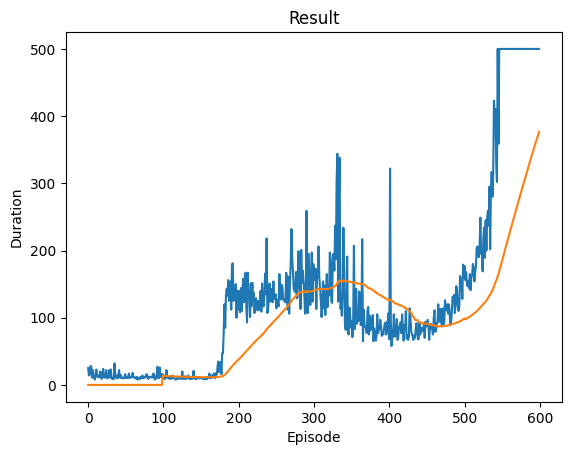

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [64]:
for i_episode in range(600):
    # Initialize the environment and get its state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
pyplot.ioff()
pyplot.show()

# Skating Rink

In [9]:
left = -1
none = 0
right = 1

speed = .1
ang_speed = 1/10 * (2 * numpy.pi)

end = numpy.array([10, 10])

class SkatingRinkEnv(gym.Env):
    state : ndarray

    def __init__(self):
        super(SkatingRinkEnv, self).__init__()
        self.action_space = spaces.Discrete(3)  # Left and right actions
        self.observation_space = spaces.Box(low=numpy.array([0, 0, -numpy.pi]), high=numpy.array([100, 100, numpy.pi]), dtype=numpy.float32)  # Example bounds

        # Initialize state
        self.state = numpy.zeros(3)

    def step(self, action : int) -> tuple[ndarray, float, bool, dict]:
        self.state = numpy.array([
            self.state[0] + action * speed * numpy.sin(self.state[2]),
            self.state[1] + action * speed * numpy.cos(self.state[2]),
            self.state[2] + ang_speed * action,
        ])

        coords = self.state[[0, 1]]
        done = numpy.sqrt(numpy.sum((coords - end) ** 2)) < 1
        reward = 1 if done else -0.01
        info = {}

        return self.state, reward, done, info

    def reset(self) -> ndarray:
        self.state = numpy.zeros(3)

In [10]:
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)  # First fully connected layer
        self.fc2 = nn.Linear(64, 64)         # Second fully connected layer
        self.fc3 = nn.Linear(64, output_dim) # Output layer

    def forward(self, x):
        x = F.relu(self.fc1(x))  # Activation function for first layer
        x = F.relu(self.fc2(x))  # Activation function for second layer
        x = self.fc3(x)          # No activation function for output layer
        return x

In [12]:
env = SkatingRinkEnv()
model = DQN(env.observation_space.shape[0], output_dim = env.action_space.n)

optimizer = optim.Adam(model.parameters(), lr = .001)

In [13]:
from collections import deque
import random

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

In [18]:
episodes = 1  # Total episodes
gamma = 0.99  # Discount factor for future rewards
epsilon_start = 1.0  # Starting value of epsilon
epsilon_end = 0.01  # Minimum value of epsilon
epsilon_decay = 500  # Decay rate of epsilon
batch_size = 64
replay_buffer = ReplayBuffer(10000)
target_update = 10  # Update the target network every 10 episodes

# Decay function for epsilon
def epsilon_by_episode(episode):
    return epsilon_end + (epsilon_start - epsilon_end) * numpy.exp(-1. * episode / epsilon_decay)

In [27]:
# Training loop
loss_fn = torch.nn.MSELoss()
for episode in range(episodes):
    state = env.reset()
    epsilon = epsilon_by_episode(episode)
    episode_rewards = 0

    while True:
        # Epsilon-greedy action selection
        if random.random() < epsilon:
            action = env.action_space.sample()
        else:
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).unsqueeze(0)
                action = model(state_tensor).argmax().item()

        # Take action and observe the next state and reward
        next_state, reward, done, _ = env.step(action)

        # Store the transition in the replay buffer
        replay_buffer.push(state, action, reward, next_state, done)

        # Move to the next state
        state = next_state
        episode_rewards += reward

        # Start learning once the replay buffer has enough samples
        if len(replay_buffer) > batch_size:
            batch = replay_buffer.sample(batch_size)
            batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones = [list(x) for x in zip(*batch)]

            print(f'{type(batch_states)}: {batch_states}')
            batch_states = torch.FloatTensor(batch_states)
            batch_actions = torch.LongTensor(batch_actions)
            batch_rewards = torch.FloatTensor(batch_rewards)
            batch_next_states = torch.FloatTensor(batch_next_states)
            batch_dones = torch.FloatTensor(batch_dones)

            # Compute the current Q values
            current_q = model(batch_states).gather(1, batch_actions.unsqueeze(1)).squeeze(1)

            # Compute the next Q values using the target network
            next_q = model(batch_next_states).max(1)[0]
            expected_q = batch_rewards + gamma * next_q * (1 - batch_dones)

            # Compute the loss and update the network
            loss = loss_fn(current_q, expected_q.detach())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if done:
            print(f"Episode: {episode}, Total Reward: {episode_rewards}")
            break

    # Update the target network
    if episode % target_update == 0:
        # Assuming you have a target network called target_model
        target_model.load_state_dict(model.state_dict())

<class 'list'>: [array([ 0.24898983,  0.1809017 , 22.61946711]), array([0.24898983, 0.1809017 , 9.42477796]), array([ 0.24898983,  0.0809017 , 16.96460033]), array([0.1902113 , 0.2618034 , 8.79645943]), array([-0.03632713,  0.1118034 , 18.84955592]), array([ 0.24898983,  0.1809017 , 22.61946711]), array([ 0.1902113 , -0.0618034 ,  5.02654825]), array([-1.40008449e-01, -7.29490169e-03,  3.76991118e+01]), None, array([ 0.24898983,  0.1809017 , 22.61946711]), array([ 0.24898983,  0.1809017 , 22.61946711]), array([-4.89858720e-17,  2.00000000e-01,  7.53982237e+00]), array([ 0.1902113 ,  0.3236068 , 15.07964474]), array([ 0.10898138,  0.2736068 , 33.92920066]), array([ 0.15388418, -0.05      , 11.30973355]), array([ 0.24898983, -0.0190983 , 10.68141502]), array([6.93889390e-18, 6.18033989e-02, 1.25663706e+01]), array([0.30776835, 0.1       , 3.76991118]), array([ 0.05877853,  0.3427051 , 20.73451151]), array([0.        , 0.1       , 0.62831853]), array([ 0.24898983,  0.1809017 , 22.61946711

TypeError: not a sequence

In [28]:
torch.FloatTensor(batch_states)

TypeError: not a sequence

In [29]:
batch_states

[array([ 0.24898983,  0.1809017 , 22.61946711]),
 array([0.24898983, 0.1809017 , 9.42477796]),
 array([ 0.24898983,  0.0809017 , 16.96460033]),
 array([0.1902113 , 0.2618034 , 8.79645943]),
 array([-0.03632713,  0.1118034 , 18.84955592]),
 array([ 0.24898983,  0.1809017 , 22.61946711]),
 array([ 0.1902113 , -0.0618034 ,  5.02654825]),
 array([-1.40008449e-01, -7.29490169e-03,  3.76991118e+01]),
 None,
 array([ 0.24898983,  0.1809017 , 22.61946711]),
 array([ 0.24898983,  0.1809017 , 22.61946711]),
 array([-4.89858720e-17,  2.00000000e-01,  7.53982237e+00]),
 array([ 0.1902113 ,  0.3236068 , 15.07964474]),
 array([ 0.10898138,  0.2736068 , 33.92920066]),
 array([ 0.15388418, -0.05      , 11.30973355]),
 array([ 0.24898983, -0.0190983 , 10.68141502]),
 array([6.93889390e-18, 6.18033989e-02, 1.25663706e+01]),
 array([0.30776835, 0.1       , 3.76991118]),
 array([ 0.05877853,  0.3427051 , 20.73451151]),
 array([0.        , 0.1       , 0.62831853]),
 array([ 0.24898983,  0.1809017 , 22.6194